<a href="https://colab.research.google.com/github/HHansi/Applied-AI-Course/blob/main/Time%20Series%20Analysis/Time_Series_Models_Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Models (Part 1)

This notebook contains the practical examples and exercises for the Applied AI-Time Series Models. 

*Adapted from a tutorial by Dr Iain Rice. Modified by Hansi Hettiarachchi.*

Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
import statsmodels.api as sm
import itertools
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from scipy.spatial.distance import cdist

# ARMA

In [ ]:
# load co2 data from stat models
dataset = sm.datasets.co2.load_pandas()

# get DataFrame in Dataset Object returned by stat models
df = dataset.data

print(df.shape)
df.head(15)

(2284, 1)


,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4
1958-05-03,316.9
1958-05-10,NaN
1958-05-17,317.5
1958-05-24,317.9
1958-05-31,NaN


## Data Wrangling


1.   Formatting
2.   Imputing missing values



Pandas [DateOffset objects](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects)

In [ ]:
# calculate mean value per month and assigned in to the calendar month begin date (DateOffset string - 'MS')
df = df.resample('MS').mean()

print(df.shape)
df.head()

(526, 1)


,co2
1958-03-01,316.100000
1958-04-01,317.200000
1958-05-01,317.433333
1958-06-01,NaN
1958-07-01,315.625000


In [ ]:
# find if the data set contains Null/NaN value
df.isna().sum()

co2    5
dtype: int64

In [ ]:
# impute missing values
# dataframe.bfill() is used to backward fill the missing values in the dataset.
df = df.fillna(df.bfill())
df.head()

,co2
1958-03-01,316.100000
1958-04-01,317.200000
1958-05-01,317.433333
1958-06-01,315.625000
1958-07-01,315.625000


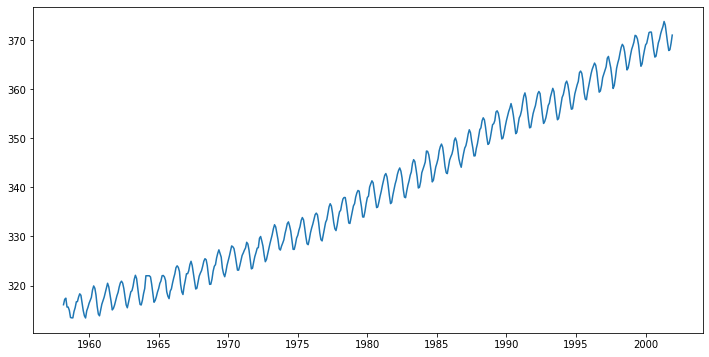

In [ ]:
# plot time series
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['co2'])
plt.show()

In [ ]:
# check stationarity of the series
def check_stationarity(series):
  statistic, p_value, n_lags, critical_values = sm.tsa.stattools.kpss(series)
  print(f'p value: {p_value}')
  print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary \n')

In [ ]:
check_stationarity(df['co2'])

p value: 0.01
Result: The series is not stationary 



/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


## Forecasting

Since the data has a seasonal component, we can use a SARIMA model.

[statsmodels SARIMAX- Documentation](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html)

[statsmodels SARIMAX Results-Documentation](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.html)

In [ ]:
# order - The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters.
# seasonal_order - The (P,D,Q,s) order of the seasonal component of the model for the AR parameters, differences, MA parameters, and periodicity.
model = sm.tsa.statespace.SARIMAX(df['co2'],
                                  order=(0, 0, 1),
                                  seasonal_order=(0, 0, 0, 12),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
# train model
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    co2   No. Observations:                  526
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -3438.524
Date:                Fri, 20 Jan 2023   AIC                           6881.049
Time:                        17:28:28   BIC                           6889.572
Sample:                    03-01-1958   HQIC                          6884.386
                         - 12-01-2001                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          1.0000     54.674      0.018      0.985    -106.159     108.159
sigma2      2.899e+04   1.59e+06      0.018      0.985   -3.08e+06    3.14e+06
Ljung-Box (L1) (Q):                 282.92   Jarque-

In [ ]:
# make predictions
preds = model_fit.predict(start=pd.to_datetime('2001-01-01'), end=pd.to_datetime('2001-12-01'), dynamic=False)
print(preds)

2001-01-01    187.832185
2001-02-01    181.988082
2001-03-01    188.969294
2001-04-01    182.735898
2001-05-01    189.671541
2001-06-01    183.773018
2001-07-01    188.922287
2001-08-01    182.027005
2001-09-01    187.038325
2001-10-01    180.495254
2001-11-01    187.196152
2001-12-01    181.831197
Freq: MS, Name: predicted_mean, dtype: float64


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


In [ ]:
# Out-of-sample forecasts
forecasts = model_fit.forecast(steps=1)
print(forecasts)

2002-01-01    188.828463
Freq: MS, dtype: float64


More model examples on how to use the other variant of ARMA models are available [here](https://www.statsmodels.org/stable/examples/index.html#time-series-analysis).

Let's go through all possible parameter combinations to identify the best.

In [ ]:
p = d = q = range(0, 3)

# generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# generate all different combinations of seasonal p, q and q triplets
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
seasonal_pdq = [(1, 1, 1, 12)]

for param in pdq:
    for param_seasonal in seasonal_pdq:
          mod = sm.tsa.statespace.SARIMAX(df['co2'],
                                          order=param,
                                          seasonal_order=param_seasonal,
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)

          mod_fit = mod.fit()

          print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, mod_fit.aic))

ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1044.7647912859954
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:807.0912988496113
ARIMA(0, 0, 2)x(1, 1, 1, 12)12 - AIC:700.9035675198329
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:323.3246481201191
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:281.5189940548696
ARIMA(0, 1, 2)x(1, 1, 1, 12)12 - AIC:279.87057679853217
ARIMA(0, 2, 0)x(1, 1, 1, 12)12 - AIC:781.4979258244898
ARIMA(0, 2, 1)x(1, 1, 1, 12)12 - AIC:332.5321368118837
ARIMA(0, 2, 2)x(1, 1, 1, 12)12 - AIC:290.71897417574894
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:327.580853205266
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:285.746383294727
ARIMA(1, 0, 2)x(1, 1, 1, 12)12 - AIC:282.99941588051064
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:293.7426222931922
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:277.7802153145717
ARIMA(1, 1, 2)x(1, 1, 1, 12)12 - AIC:279.4750046782422
ARIMA(1, 2, 0)x(1, 1, 1, 12)12 - AIC:572.1786409603675


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 1)x(1, 1, 1, 12)12 - AIC:303.99053518572947
ARIMA(1, 2, 2)x(1, 1, 1, 12)12 - AIC:286.3363196172022
ARIMA(2, 0, 0)x(1, 1, 1, 12)12 - AIC:293.8643507215896


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(1, 1, 1, 12)12 - AIC:279.4448386984216


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2)x(1, 1, 1, 12)12 - AIC:281.10525686862195
ARIMA(2, 1, 0)x(1, 1, 1, 12)12 - AIC:288.9646784916603
ARIMA(2, 1, 1)x(1, 1, 1, 12)12 - AIC:281.63283636918726
ARIMA(2, 1, 2)x(1, 1, 1, 12)12 - AIC:281.5545799081767
ARIMA(2, 2, 0)x(1, 1, 1, 12)12 - AIC:501.1094516323386
ARIMA(2, 2, 1)x(1, 1, 1, 12)12 - AIC:297.2999362181496


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2)x(1, 1, 1, 12)12 - AIC:288.0733179578527


In [ ]:
# specify model
model = sm.tsa.statespace.SARIMAX(df['co2'],
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
# train model
model_fit = model.fit()

# make predictions
preds = model_fit.predict(start=pd.to_datetime('1998-01-01'), dynamic=False)

# calculate MSE
actuals = df['1998-01-01':]
print(f'Mean Squared Error: {round(mean_squared_error(actuals, preds), 2)}')

Mean Squared Error: 0.07


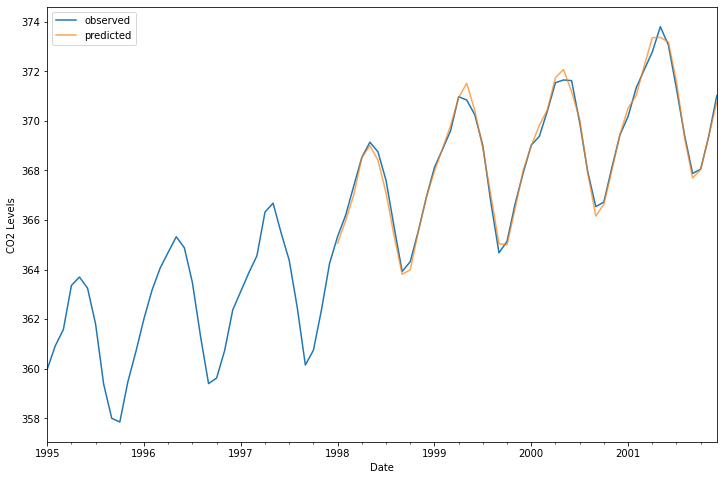

In [ ]:
# plot observations and predictions
ax = df['1995':]['co2'].plot(label='observed', figsize=(12, 8))
preds.plot(ax=ax, label='predicted', alpha=.7)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()

**Exercise 1**

Build an appropriate ARMA model to predict the number of international airline passengers during the months in the first quarter of 1961 using the dataset *international-airline-passengers.csv*.

# Exponential Smoothing

In [ ]:
# load the data set
# As the parameter, the file path should be provided. Additionally, GitHub URL can also be provided as follows.
df = pd.read_csv('https://raw.githubusercontent.com/HHansi/Applied-AI-Course/main/Time%20Series%20Analysis/data/international-airline-passengers.csv')

# rename column name
df = df.rename(columns={"International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60": "Sales"})

# convert month to int
df['Month-No'] = list(range(0, len(df['Month'])))

df.head()

,Month,Sales,Month-No
0,1949-01,112,0
1,1949-02,118,1
2,1949-03,132,2
3,1949-04,129,3
4,1949-05,121,4


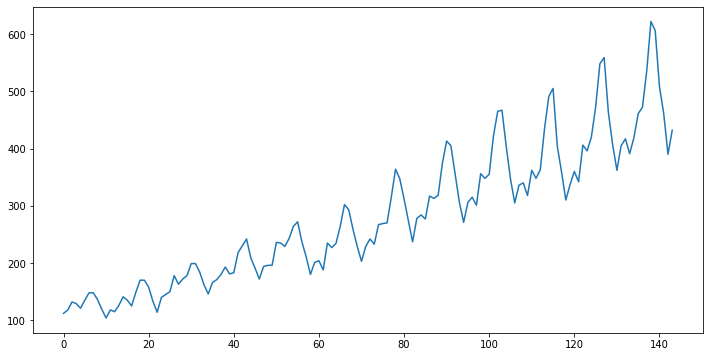

In [ ]:
# plot time series
plt.figure(figsize=(12, 6))
plt.plot(df["Month-No"],df["Sales"])
plt.show()

Documentation:
* [SimpleExpSmoothing](https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html)
* [Holt](https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.Holt.html#statsmodels.tsa.holtwinters.Holt)
* [ExponentialSmoothing](https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html#statsmodels.tsa.holtwinters.ExponentialSmoothing)

In the following, we use auto optimization instead of choosing model parameters manually.

More examples on exponential smoothing are available [here](https://www.statsmodels.org/stable/examples/notebooks/generated/exponential_smoothing.html#Simple-Exponential-Smoothing). Additionally, a tutorial is available [here](https://medium.com/analytics-vidhya/python-code-on-holt-winters-forecasting-3843808a9873).


In [ ]:
# single exponential smoothing
single_fit = SimpleExpSmoothing(df["Sales"]).fit()

# double exponential smoothing
double_fit = Holt(df["Sales"]).fit()

# triple exponential smoothing
tripple_fit = ExponentialSmoothing(df["Sales"], trend="mul",seasonal="mul", seasonal_periods=12).fit()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


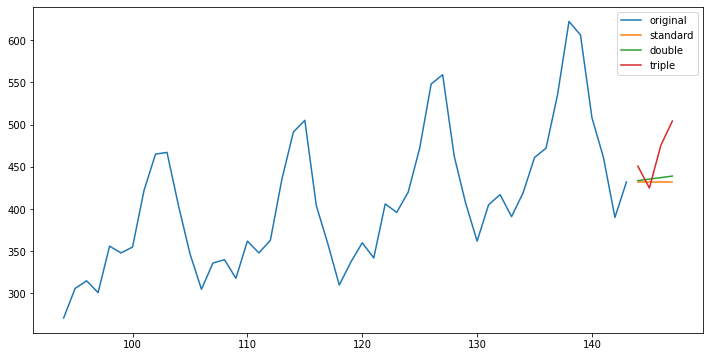

In [ ]:
# future predictions
predictions_single_fit = single_fit.forecast(4)
predictions_double_fit = double_fit.forecast(4)
predictions_tripple_fit = tripple_fit.forecast(4)

# plot data
fig, ax = plt.subplots(figsize=(12, 6)) 
ax.plot(df["Month-No"][-50:], df["Sales"][-50:], label='original')

plt.plot(predictions_single_fit, label='standard')
plt.plot(predictions_double_fit, label='double')
plt.plot(predictions_tripple_fit, label='triple')

plt.legend()
plt.show()

**Exercise 2**

Compare the predictions made using exponential smoothing above and the model you built in exercise 1 on the international airline passengers dataset.

# Lorenz Method of Analogues (LMA)

Example with City Temperatures Dataset. Need to do some data pre-processing and wrangling first.

## Data Loading

In [ ]:
# mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # unzip file
# import shutil
# shutil.unpack_archive('/content/drive/MyDrive/Colab Notebooks/Applied-AI/Time-Series/data/city_temperature.zip', '/content/drive/MyDrive/Colab Notebooks/Applied-AI/Time-Series/data', 'zip')

In [ ]:
# load data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Applied-AI/Time-Series/data/city_temperature.csv')
df.head()

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9


## Data Wrangling

In [ ]:
# get a statistical summary of the DataFrame
df.describe()

,Month,Day,Year,AvgTemperature
count,2.906327e+06,2.906327e+06,2.906327e+06,2.906327e+06
mean,6.469163e+00,1.571682e+01,2.006624e+03,5.600492e+01
std,3.456489e+00,8.800534e+00,2.338226e+01,3.212359e+01
min,1.000000e+00,0.000000e+00,2.000000e+02,-9.900000e+01
25%,3.000000e+00,8.000000e+00,2.001000e+03,4.580000e+01
50%,6.000000e+00,1.600000e+01,2.007000e+03,6.250000e+01
75%,9.000000e+00,2.300000e+01,2.013000e+03,7.550000e+01
max,1.200000e+01,3.100000e+01,2.020000e+03,1.100000e+02


In [ ]:
# find if the DataFrame contains Null/NaN values
df.isna().sum()

Region                  0
Country                 0
State             1450990
City                    0
Month                   0
Day                     0
Year                    0
AvgTemperature          0
dtype: int64

In [ ]:
# get regions in the dataframe:
df.Region.unique()

array(['Africa', 'Asia', 'Australia/South Pacific', 'Europe',
       'Middle East', 'North America',
       'South/Central America & Carribean'], dtype=object)

So the temperatures are stored in farenheight and as a more modern group we want to work with celsius.

In [ ]:
# function to transform farenheight to celsius
def to_celsius(row):
    return round((row-32) * (5/9),1)

# apply the to_celsius function to all values in column 'AvgTemperature'
df['AvgTemperature'] = df['AvgTemperature'].apply(to_celsius)
df.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,17.9
1,Africa,Algeria,NaN,Algiers,1,2,1995,9.7
2,Africa,Algeria,NaN,Algiers,1,3,1995,9.3
3,Africa,Algeria,NaN,Algiers,1,4,1995,8.0
4,Africa,Algeria,NaN,Algiers,1,5,1995,8.8


We can get a summary of what's going on within a dataset by grouping subcategories together.

In [ ]:
# get the averages of the dataframe for each Region-Country-State-City and Year
df.groupby(['Region','Country','State','City','Year']).mean()

Month  \
Region        Country State                  City                 Year             
North America US      Additional Territories San Juan Puerto Rico 1995  6.526027   
                                                                  1996  6.513661   
                                                                  1997  6.526027   
                                                                  1998  6.526027   
                                                                  1999  6.526027   
...                                                                          ...   
                      Wyoming                Cheyenne             2016  6.513661   
                                                                  2017  6.526027   
                                                                  2018  6.526027   
                                                                  2019  6.526027   
                                                                  2020  2.738806   

                                                                              Day  \
Region        Country State                  City                 Year              
North America US      Additional Territories San Juan Puerto Rico 1995  15.720548   
                                                                  1996  15.756831   
                                                                  1997  15.720548   
                                                                  1998  15.720548   
                                                                  1999  15.720548   
...                                                                           ...   
                      Wyoming                Cheyenne             2016  15.756831   
                                                                  2017  15.720548   
                                                                  2018  15.720548   
                                                                  2019  15.720548   
                                                                  2020  14.798507   

                                                                        AvgTemperature  
Region        Country State                  City                 Year                  
North America US      Additional Territories San Juan Puerto Rico 1995       27.008493  
                                                                  1996      -15.196721  
                                                                  1997       15.360548  
                                                                  1998       11.422466  
                                                                  1999       16.188767  
...                                                                                ...  
                      Wyoming                Cheyenne             2016        9.178689  
                                                                  2017        9.107397  
                                                                  2018        8.496164  
                                                                  2019        7.590959  
                                                                  2020        1.961940  

[4031 rows x 3 columns]

Sometimes we know what city we want information for so can get a *slice* of the dataframe for subsequent plotting and analysis. 

In [ ]:
# get data of 'Vienna'
vienna = df[df['City']=='Vienna'].copy()
vienna.head()

# get the averages of the dataframe for year
vienna = vienna.groupby(['Year']).mean()

vienna = vienna.drop(columns=['Month','Day'])
vienna.head()

,AvgTemperature
Year,
1995,10.137260
1996,8.710109
1997,9.825479
1998,9.827671
1999,10.301096


Let's see a plot to get a really good idea of what's gone on here.

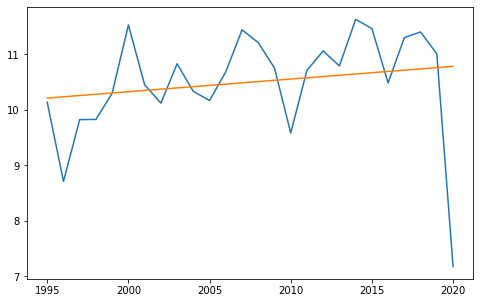

In [ ]:
# Plotting a line chart
plt.figure(figsize=(8, 5))
plt.plot(vienna.index, vienna['AvgTemperature']) 

# fit a linear regression (trend)
m, b = np.polyfit(vienna.index, vienna['AvgTemperature'], 1)
plt.plot(vienna.index, m * vienna.index + b)

So here we've got an idea of what's going on, but there's a significant drop in 2020. What could be causing this? Let's explore and see the values for each year to check that 2020 is plotting correctly. Then let's view the time series for 2018-2020 and see what's going on with the trend.

In [ ]:
vienna.tail()

,AvgTemperature
Year,
2016,10.484699
2017,11.304384
2018,11.404384
2019,11.010959
2020,7.178358


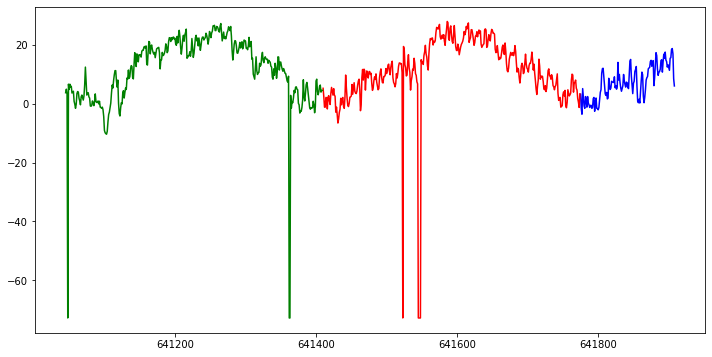

In [ ]:
sliced = df[df['City']=='Vienna'].copy()

plt.figure(figsize=(12, 6))

# plot 2020 temperature values
sliced_20 = sliced[sliced['Year']==2020]
plt.plot(sliced_20.index, sliced_20['AvgTemperature'], color='b')

# plot 2019 temperature values
sliced_19 = sliced[sliced['Year']==2019]
plt.plot(sliced_19.index, sliced_19['AvgTemperature'], color='r') 

# plot 2018 temperature values
sliced_18 = sliced[sliced['Year']==2018]
plt.plot(sliced_18.index, sliced_18['AvgTemperature'], color='g') 

So we should notice why 2020 is looking different on the averages listed above from this plot. What this has also highlighted is the fact that there are some uncharacteristically low values in 2018 and 2019. This data may actually need cleaning to avoid undue effects on subsequent modelling.

In [ ]:
print(f"Number of null values: {sum(sliced_18['AvgTemperature'].isnull())}")
print(f"Number of N\A values: {sum(sliced_18['AvgTemperature'].isna())}")
print(f"Number of low values (<-20): {sum(sliced_18['AvgTemperature']<-20)}")

Number of null values: 0
Number of N\A values: 0
Number of low values (<-20): 3


Let's look into these 3 low values in more detail.

In [ ]:
print(sliced_18[sliced_18['AvgTemperature']<-20])

        Region  Country State    City  Month  Day  Year  AvgTemperature
641048  Europe  Austria   NaN  Vienna      1    4  2018           -72.8
641362  Europe  Austria   NaN  Vienna     11   14  2018           -72.8
641363  Europe  Austria   NaN  Vienna     11   15  2018           -72.8


So there is clearly values included here in error since Vienna couldn't have -72.8 Celsius weather on these three days. We have a few options here to *clean* this bad data:

i)  We can cut it from the dataframe

ii) We can *impute* it

In [ ]:
# get indices of bad data
sliced_18[sliced_18['AvgTemperature']<-20].index

Int64Index([641048, 641362, 641363], dtype='int64')

In [ ]:
# print the shape - (row,column) 
print(sliced_18.shape)

# remove the row with index 641048
sliced_18 = sliced_18.drop(index=641048)

print(sliced_18.shape)

(365, 8)
(364, 8)


Now let's impute the remaining bad value pair using the mean of the data either side, or the median  of the month.

In [ ]:
print(sliced_18.loc[641360:641365])

        Region  Country State    City  Month  Day  Year  AvgTemperature
641360  Europe  Austria   NaN  Vienna     11   12  2018             7.3
641361  Europe  Austria   NaN  Vienna     11   13  2018             9.3
641362  Europe  Austria   NaN  Vienna     11   14  2018           -72.8
641363  Europe  Austria   NaN  Vienna     11   15  2018           -72.8
641364  Europe  Austria   NaN  Vienna     11   16  2018             2.8
641365  Europe  Austria   NaN  Vienna     11   17  2018            -1.5


In [ ]:
# replace 'AvgTemperature' at row index 641362 by the average of values at row indices 641361 and 641364
sliced_18.at[641362,'AvgTemperature'] = 0.5*(sliced_18.at[641361,'AvgTemperature'] + sliced_18.at[641364,'AvgTemperature'])

print(sliced_18.loc[641360:641365])

        Region  Country State    City  Month  Day  Year  AvgTemperature
641360  Europe  Austria   NaN  Vienna     11   12  2018            7.30
641361  Europe  Austria   NaN  Vienna     11   13  2018            9.30
641362  Europe  Austria   NaN  Vienna     11   14  2018            6.05
641363  Europe  Austria   NaN  Vienna     11   15  2018          -72.80
641364  Europe  Austria   NaN  Vienna     11   16  2018            2.80
641365  Europe  Austria   NaN  Vienna     11   17  2018           -1.50


In [ ]:
# replace 'AvgTemperature' at row index 641363 by the median of values at row indices 641355-641361
sliced_18.at[641363,'AvgTemperature'] = sliced_18.loc[641355:641361,"AvgTemperature"].median()

print(sliced_18.loc[641360:641365])

        Region  Country State    City  Month  Day  Year  AvgTemperature
641360  Europe  Austria   NaN  Vienna     11   12  2018            7.30
641361  Europe  Austria   NaN  Vienna     11   13  2018            9.30
641362  Europe  Austria   NaN  Vienna     11   14  2018            6.05
641363  Europe  Austria   NaN  Vienna     11   15  2018            9.30
641364  Europe  Austria   NaN  Vienna     11   16  2018            2.80
641365  Europe  Austria   NaN  Vienna     11   17  2018           -1.50


So now we've dropped one from the dataset, replaced another with the mean of surrounding points and the other with the median. 

Let's look at the updated plot now.

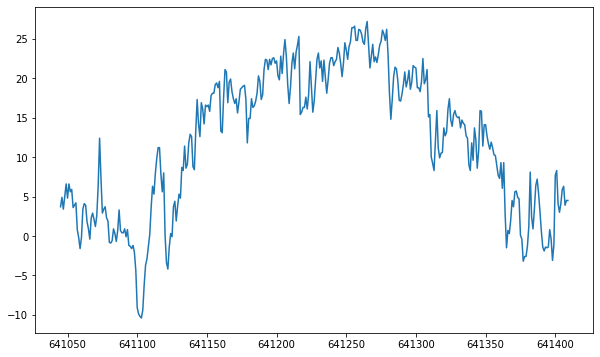

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(sliced_18.index, sliced_18['AvgTemperature'])

## Forecasting

In [ ]:
# get values in column 'AvgTemperature' as a numpy array
x = sliced_18['AvgTemperature'].to_numpy()

# get delay embedding series
X = np.vstack((x[:-2],x[1:-1],x[2:])).T
print(X.shape)

(362, 3)


In [ ]:
# get 250 entries as historic data
history = X[:250,:]
print("Stacked data with delay embedding 3:")
print(history[-5:,:])

# identify target
test = x[252]
print(f"\n Target to predict: {test}")

# get latest data
latest = np.reshape(history[-1,:],(-1,3))
print(f"\n Latest observation:{latest}")

Stacked data with delay embedding 3:
[[19.2 20.8 18.9]
 [20.8 18.9 19.7]
 [18.9 19.7 21. ]
 [19.7 21.  18.6]
 [21.  18.6 19.5]]

 Target to predict: 21.6

 Latest observation:[[21.  18.6 19.5]]


In [ ]:
# find data like most recent observation (latest)
z = cdist(history[:-1], latest)
zz = np.argsort(z, axis=0)  # return indices of sorted values

print("Five nearest neighbors from history:")
print(history[zz[:5,0],:])

Five nearest neighbors from history:
[[20.8 18.9 19.7]
 [20.1 18.1 19.8]
 [19.4 18.8 19.6]
 [20.8 16.9 19.5]
 [19.2 19.4 18.8]]


In [ ]:
# standard prediction:
pred = x[zz[0,0]+3]
print(f"Standard prediction: {pred}")

# average prediction:
neighbours = 2
pred2 = (1/neighbours)*sum(x[zz[:neighbours,0]+3])
print(f"\nAveraged prediction: {pred2}")

Standard prediction: 21.0

Averaged prediction: 21.45


**Exercise 3**

1. Change the number of neighbours and see its impact on the final prediction.
2. Does a high number of neighbours always give the best prediction?

**Exercise 4**

1. Make the data stationary and see how it affects the results of LMA.
2. Pick another city of interest, do necessary data wrangling, and model using LMA.